In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # insert data as a pandas dataframe
    
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input saquence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... )
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)#bvc
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def fea_in_weeksaz(fea_idx, total_feas=390, week_size=6):
    count = 0
    while total_feas >= 0:
        if fea_idx == total_feas:
            return str(count)+' week ago'
        else:
            count += 1
            total_feas = total_feas - DAY_PROC*week_size
    return np.nan
            
def fea_in_daysaz(fea_idx, total_feas=390):
    count = 0
    while total_feas >= 0:
        if fea_idx == total_feas:
            return str(count)+' days ago'
        else:
            count += 1
            total_feas = total_feas - DAY_PROC
    return np.nan

In [4]:
df = pd.read_csv('st0050(no_sunday).csv', index_col='ds', parse_dates=True)
df_proc = df[['n_clients','imputed']]
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23582 entries, 2015-01-02 09:00:00 to 2020-10-17 21:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   n_clients  23582 non-null  float64
 1   imputed    23582 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 552.7 KB


In [5]:
TRAIN = ['2018-10', '2019-05', '2020-01']
TEST = ['2018-11', '2019-06', '2020-02']

DAY_ZEROS = 24
DAY_PROC = 13

0.8188392194944752
121.51315463952062
Test #1 ended.
0.8795569623078103
86.80963328122436
Test #2 ended.
0.8669572972558743
104.61460482677424
Test #3 ended.


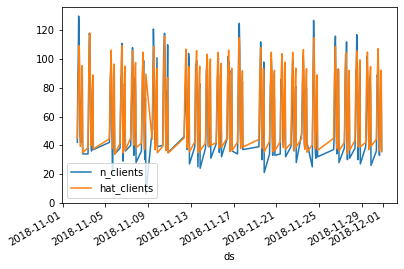

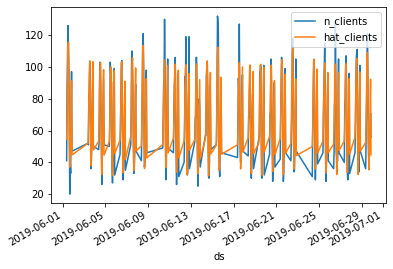

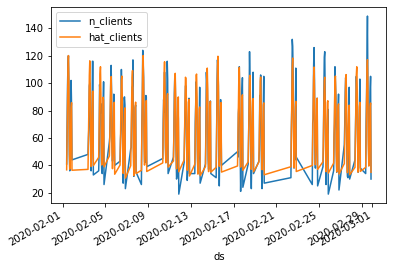

In [6]:
for test in range(len(TEST)):
    d = df_proc[:TRAIN[test]][['n_clients']]
    sc = StandardScaler()
    d['sc_clients'] = sc.fit_transform(d)

    d_test = df_proc[TEST[test]][['n_clients']]
    d_test['sc_clients'] = sc.transform(d_test)
    
    super_df = series_to_supervised(d[['sc_clients']], n_in=30*DAY_PROC)
    
    x_train = super_df.to_numpy()[:,:-1]
    y_train = np.reshape(super_df.to_numpy()[:,-1], (-1,1))
    y_test = d_test['sc_clients'].to_numpy()
    
    svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
    svr.fit(x_train, y_train)
    
    # estrutura auto-regressiva
    fea = np.append(x_train[-1,1:], y_train[-1])
    pred = svr.predict(fea.reshape(1, -1))
    y_hat = np.array(pred)
    for i in range(y_test.shape[0]-1):
        fea = np.append(fea[1:], pred)
        pred = svr.predict(fea.reshape(1, -1))
        y_hat = np.append(y_hat, pred)
        
    d_test['hat_clients'] = sc.inverse_transform(y_hat.reshape(-1,1))
    
    d_test['error'] = d_test['n_clients'] - d_test['hat_clients']
    
    # post-processing
    d_test['imputed'] = df[TEST[test]]['imputed']
    d_test = d_test.loc[d_test['imputed'] == -1]
    
    d_test[['n_clients','hat_clients']].plot()
    print(r2_score(d_test['n_clients'], d_test['hat_clients']))
    print(mean_squared_error(d_test['n_clients'], d_test['hat_clients']))
    
    #f_name = 'proc_'+str(TEST[test])+'.csv'
    #d_test.to_csv(f_name)
    
    print('Test #'+str(test+1)+' ended.')

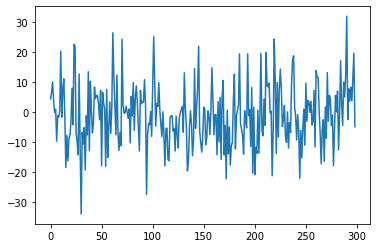

In [7]:
plt.plot(d_test['error'].to_numpy())

In [8]:
fea_imp = abs(svr.coef_)
#fea_imp

In [9]:
fea_df = pd.DataFrame()
fea_df['fea_imp'] = fea_imp
fea_df['fea_name'] = super_df.columns[:-1]
fea_df['saz'] = np.nan
fea_df.reset_index(inplace=True)
fea_df.loc[fea_df['saz'].isnull(), 'saz'] = fea_df['index'].apply(fea_in_weeksaz)
fea_df.loc[fea_df['saz'].isnull(), 'saz'] = fea_df['index'].apply(fea_in_daysaz)
fea_df.set_index('index', drop=True, inplace=True)

In [10]:
fea_df.sort_values('fea_imp', ascending=False).head(20)

,fea_imp,fea_name,saz
index,,,
389,0.261351,var1(t-1),NaN
312,0.152105,var1(t-78),1 week ago
388,0.094912,var1(t-2),NaN
234,0.081684,var1(t-156),2 week ago
377,0.081041,var1(t-13),1 days ago
364,0.071082,var1(t-26),2 days ago
156,0.070145,var1(t-234),3 week ago
78,0.068395,var1(t-312),4 week ago
0,0.056325,var1(t-390),5 week ago


In [11]:
svr.intercept_

array([-0.00186842])

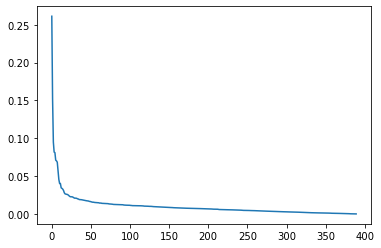

In [12]:
a = fea_df.sort_values('fea_imp', ascending=False)['fea_imp'].to_numpy()
plt.plot(a)